# Toonify (Cel-Shading)
The goal of the algorithm is to create a cel shaded image out of a normal image or well shaded object.\
**=> Check the last cell for a easy-to-use function**

### Import the picture
(Please remember to run all the cells again after choosing a new image)

In [2]:


# select the picture
#img = cv2.imread("teapot_gray.png")
#img = cv2.imread("car.jpeg")
#img = cv2.imread("face.jpg")
#img = cv2.imread("face2.jfif")
#img = cv2.imread("dolphin.jpg")
#img = cv2.imread("teapot_white.png")

### 1) Edges
First, we convert the picture to levels of gray to enable a better detection of the edges without any disruptive colors.\
\
Second, we use the **medianBlur** algorithm to blur any unwanted noise which could be interpreted as edges. MedianBlur makes sure to protect edges but blur surfaces and everything else. It uses a 13x13 pixel matrix (neighborhood) and replace each pixel with the median of its neighboring pixels. The median filter uses BORDER_REPLICATE internally to cope with border pixels.\
\
Third, we use **Canny** algorithm to finally detect edges. Even though this edge detection algorithm uses a gaussian filter to reduce noise, median filter before results in clearer edges. In stage two, Canny derives horizontal and vertical gradients by using Sobel kernel to find both edge gradient and direction for each pixel.\
In the end Canny uses thresholding to decide which pixels/lines are really edges and which are not: If a pixel's value is below the minV it is definitely not an edge, and if its value is above maxV it definitely is an edge. For every pixel between the two thresholds, Canny checks if it is connected to a pixel that's definitely part of an edge. If that is the case, it is also considered to be part of the edge.


In [3]:
def detect_edges(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 13)
    # Edge detection with canny
    edges = cv2.Canny(gray, 50, 80)
    # an invertation is necessairy to have black edges and not white ones
    edges = (255-edges)
    return edges

### 2) Colors
Now, we simplify colors in the image to create the blocky, minimalized look that creates the "cartoon"-appearance we want to achieve.
First, we start by blurring all the colors by applying the same median-blur used for the edges in Step 1), but this time we use a 7x7 pixel matrix to get more accurate values.

Next, we reshape the array into an N x 3 matrix (N=number of pixels) and convert all elements to the datatype np.float32.
This is necessary in order to use the __cv2.kmeans()__ function.\
The kmeans function finds "means" of colour within our data-array and then arranges the tuples into clusters around them. In essence, the function is passed the desired number _K_ of colours that should be in the final picture. In the end it applies the mean-values to all the tuples clustered around them. \
Other important parameters passed to the function are the following: 
- _criteria_ : defines when the function is done; in this case either after 10 iterations or when an accuracy of 1.0 is reached
- _cv2.KMEANS_RANDOM_CENTERS_ : This means that in the initial iteration, the centers(/means) are chosen randomly and improved on in the following iterations.


After this, the amount of colours has been reduced and all surfaces simplified, so all that's left to do is to reshape the array back to the proper format to be displayed. 

With this, the recoloring-process is complete.


In [13]:
def coloring(img):
    color = img.copy()
    # smooth the colors within one color area
    for _ in range(2): 
        color = cv2.medianBlur(color, 7)

    Z = color.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    color_res = res.reshape((color.shape))
    return color_res

### 3) All together
Finally, we combine the results of step 1) and step 2). We use the bitwise_and to put the color part and the edge part into one picture. The black edges are used as a mask in the AND operations between two instances of the same color picture.

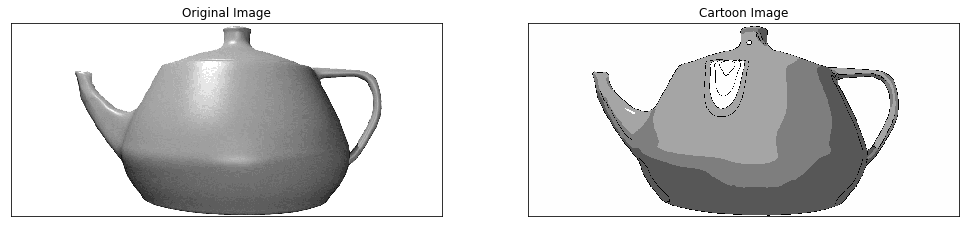

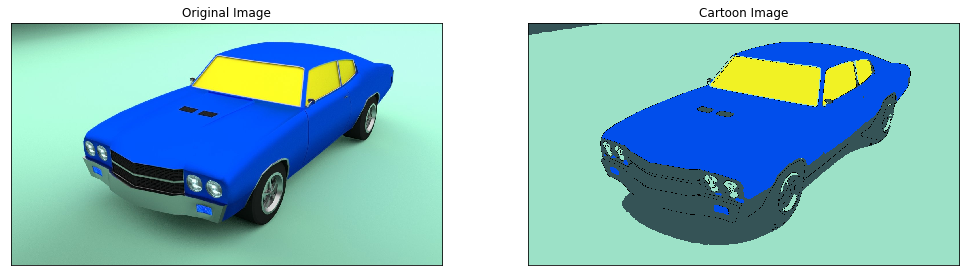

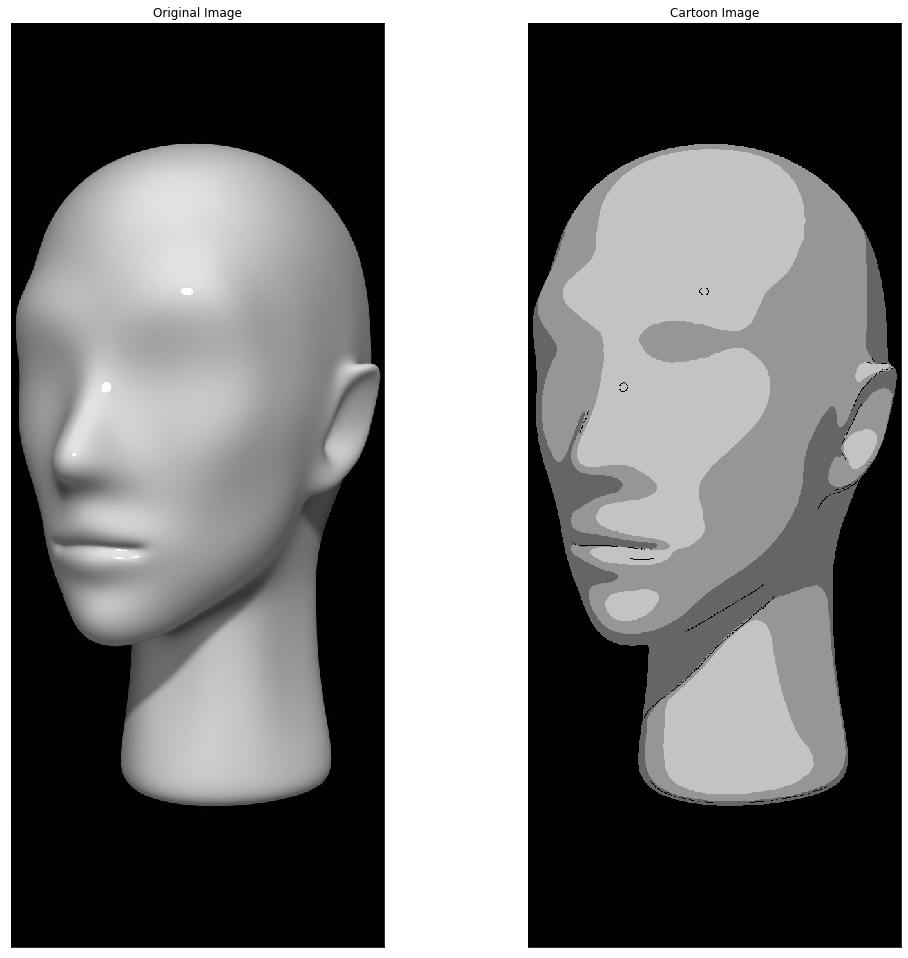

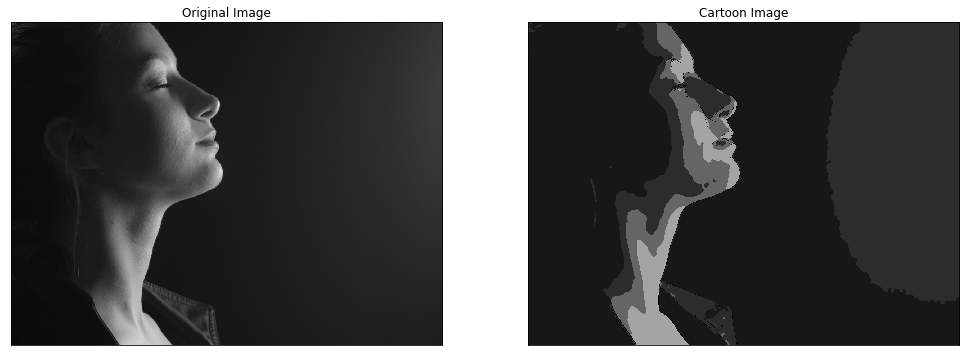

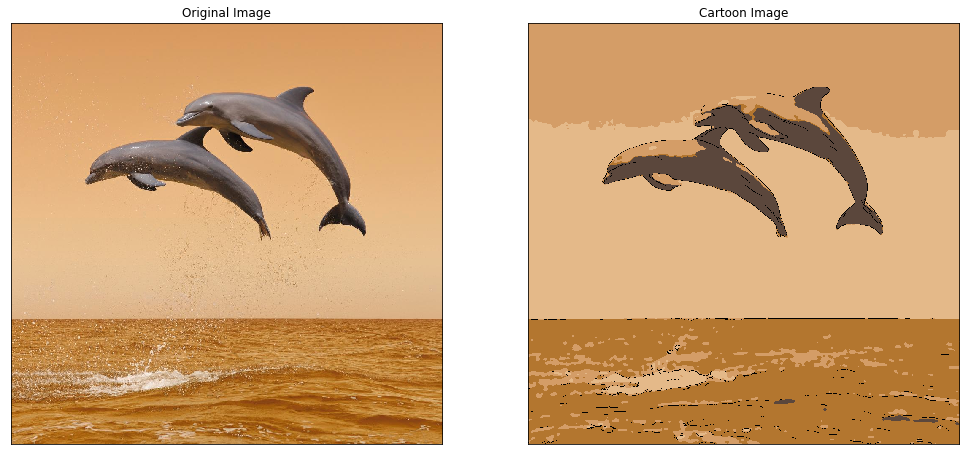

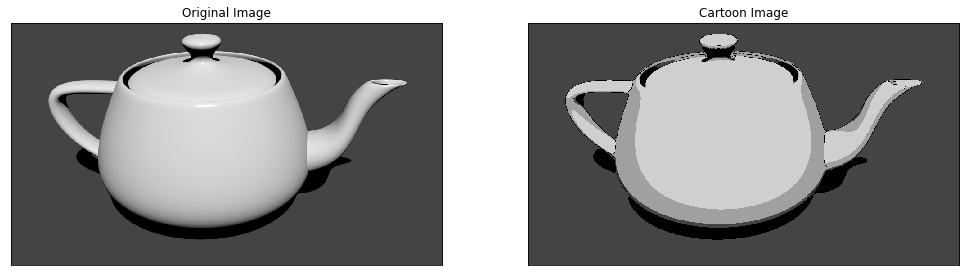

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def toonify(image):
    img = cv2.imread(image)
    edges = detect_edges(img)
    colors = coloring(img)
    cartoon = cv2.bitwise_and(colors, colors, mask=edges)
    return img,cartoon

def show(img, cartoon):
    cv2.imshow("Image", img)
    cv2.imshow("Cartoon", cartoon)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

images = ["teapot_gray.png","car.jpeg","face.jpg","face2.jfif","dolphin.jpg","teapot_white.png"]
for picture in images:
    img, result = toonify(picture)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,17))
    ax1.imshow(img)
    ax1.set_title("Original Image"), 
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.imshow(result)
    ax2.set_title("Cartoon Image"), 
    ax2.set_xticks([]), ax2.set_yticks([])
    